1. Setup dan data Downloading

In [2]:
import kagglehub
dataset_path = kagglehub.dataset_download('kausthubkannan/5-flower-types-classification-dataset')

print('Data source import complete.')

100%|██████████| 242M/242M [00:01<00:00, 190MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
Data_pth = os.path.join(dataset_path, 'flower_images')

In [4]:
os.listdir(Data_pth)

['Lilly', 'Orchid', 'Tulip', 'Sunflower', 'Lotus']

2. Loading and Processing Data

In [5]:
import pandas as pd

images = []
labels = []

try:
  for foldr in os.listdir(Data_pth):
    for filee in (os.listdir(os.path.join(Data_pth, foldr))):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)

  print(len(images), len(labels))
except Exception as e:
  print(f'Error: {e}')

5000 5000


In [6]:
all_df = pd.DataFrame({
    'Images': images,
    'Labels':labels
    })
all_df

,Images,Labels
0,Lilly/a7fb5c561d.jpg,Lilly
1,Lilly/d196bebb51.jpg,Lilly
2,Lilly/d7fe231208.jpg,Lilly
3,Lilly/6d349e828a.jpg,Lilly
4,Lilly/d0746e74f9.jpg,Lilly
...,...,...
4995,Lotus/983cf3b143.jpg,Lotus
4996,Lotus/23060e4b2a.jpg,Lotus
4997,Lotus/631db0034b.jpg,Lotus
4998,Lotus/a6336ba1eb.jpg,Lotus


3. Visualizing the Data

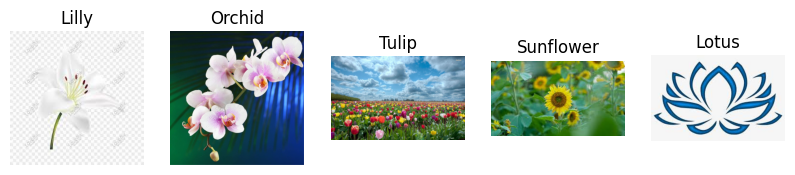

In [7]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i, label in enumerate(all_df['Labels'].unique()):
    sample = all_df[all_df['Labels'] == label].sample(1).iloc[0]
    img_path = os.path.join(Data_pth, sample['Images'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(all_df['Labels'].unique()), i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()

4. Data Splitting

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['Labels'])

5. Data Augmentation

In [9]:
imgentrain = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_data = imgentrain.flow_from_dataframe(
    dataframe=train_df,
    directory=Data_pth,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16
)

Found 4000 validated image filenames belonging to 5 classes.


In [10]:
imgentest = ImageDataGenerator(
    rescale=1./255
)

test_data = imgentest.flow_from_dataframe(
    dataframe=test_df,
    directory=Data_pth,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False # For test data, it's crucial to set shuffle=False. This ensures the prediction order matches the label order, which is necessary for correct evaluation with metrics like a confusion matrix.
)

Found 1000 validated image filenames belonging to 5 classes.


6. Building the CNN Model

In [11]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.models import Sequential

Model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(all_df['Labels'].unique()), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233,285 (4.70 MB)

 Trainable params: 1,233,285 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.optimizers import Adam
Model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

7. Model Training

In [16]:
Model.fit(
    train_data,
    validation_data=test_data,
    epochs=50
    )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 243ms/step - accuracy: 0.3422 - loss: 1.4573 - val_accuracy: 0.4950 - val_loss: 1.1884
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 247ms/step - accuracy: 0.5262 - loss: 1.1540 - val_accuracy: 0.5300 - val_loss: 1.1793
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 241ms/step - accuracy: 0.5775 - loss: 1.0670 - val_accuracy: 0.5740 - val_loss: 1.0357
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 229ms/step - accuracy: 0.5870 - loss: 1.0387 - val_accuracy: 0.5770 - val_loss: 1.0610
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.6244 - loss: 0.9410 - val_accuracy: 0.5730 - val_loss: 1.0149
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 226ms/step - accuracy: 0.6317 - loss: 0.9360 - val_accuracy: 0.6100 - val_loss: 0.9880
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.6027 - loss: 0.9745 - val_accuracy: 0.5920 - val_loss: 1.0197
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.6519 - loss: 0

#Evaluating Model performance

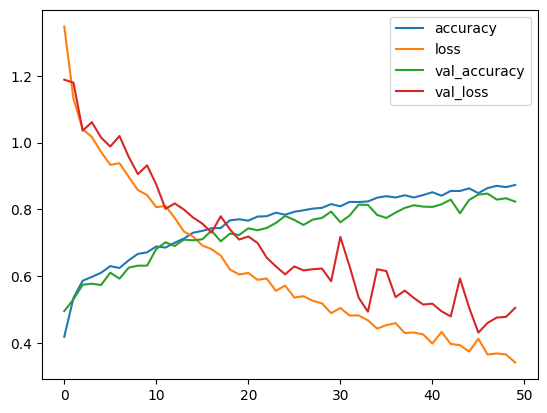

In [17]:
# Plotting the learning curves
import matplotlib.pyplot as plt
pd.DataFrame(Model.history.history).plot()
plt.show()

In [18]:
Model.evaluate(test_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8142 - loss: 0.4975


[0.5045344829559326, 0.8230000138282776]

In [26]:
 from tensorflow.keras.models import load_model
 import os
# from tensorflow.keras.layers import TFSMLayer # Removed TFSMLayer as load_model is sufficient for SavedModel format

# model_path = '/kaggle/input/cnn/scikitlearn/default/1/model.h5' # commented out the old path
model_path = 'my_model.keras' # load the model from the current working directory

if os.path.exists(model_path):
  try:
    CNNmodelfromprevSession = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
  except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
else:
  print(f"Model file not found at {model_path}. Please ensure the model is saved before attempting to load it.")


# CNNmodelfromprevSession = TFSMLayer(model_path, call_endpoint='serving_default') # Removed TFSMLayer

Model file not found at my_model.keras. Please ensure the model is saved before attempting to load it.


In [27]:
# plotting a confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

preds = CNNmodelfromprevSession.predict(test_data)
preds = np.argmax(preds, axis=1)
labels = test_data.classes

NameError: name 'CNNmodelfromprevSession' is not defined

In [33]:
from tensorflow.keras.models import load_model
import os

model_path = 'my_model.keras'

if os.path.exists(model_path):
  try:
    CNNmodelfromprevSession = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
  except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
else:
  print(f"Model file not found at {model_path}. Please ensure the model is saved before attempting to load it.")

Model loaded successfully from my_model.keras


In [34]:
# plotting a confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib

preds = CNNmodelfromprevSession.predict(test_data)
preds = np.argmax(preds, axis=1)
labels = test_data.classes

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


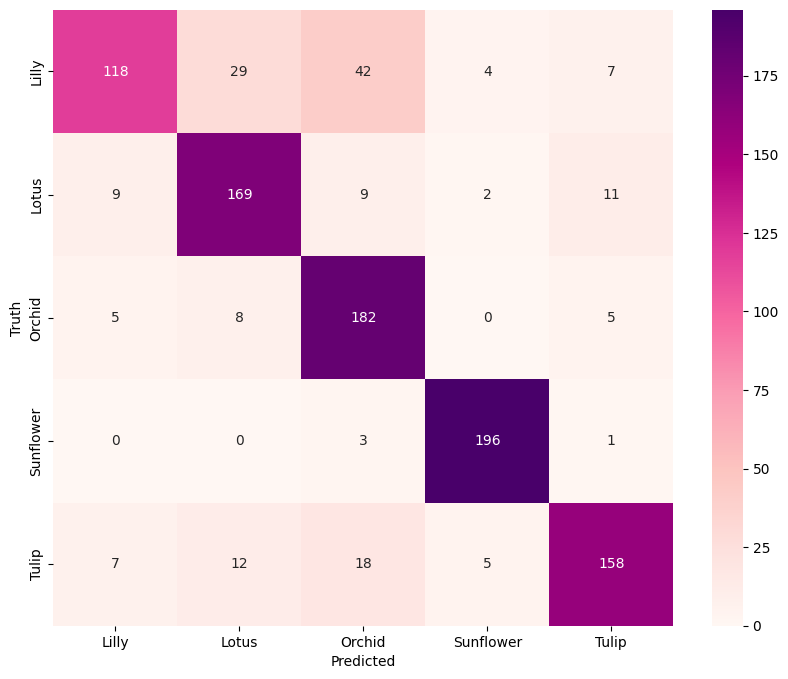

In [35]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=list(test_data.class_indices.keys()), yticklabels=list(test_data.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [37]:
Model.save('my_model.keras')

from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>